In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from cycler import cycler
#plt.rc('text', usetex=True)
#plt.rc('text.latex', preamble=r"\usepackage{amsmath}")
from loadingData import *
from loadingDynamicalData import *
import seaborn
import pickle
from scipy.interpolate import griddata
from matplotlib import cm

def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]


## Version

To reproduce the results presented in [[1]](#References), The `Comphy` of Kratos and ROM_AM should be installed. Using later/other versions can induce errors.

Previously trained ROMs are stored in the form of `.pkl` files in the `./trainedROMs` folder.
Those ROMs are constructed as described in this notebook, using Ubuntu 20.04 (X64), gcc 9.4.0 and Python 3.8. The `numpy` version is `1.22.3`.


# FSI Configuration

We extend the $2D$ test case to a higher Reynolds number, which necessitates a finer mesh as well.
Now, the available data corresponds to $Re = \{208, 250, 380\}$ and the ROM predictions will be evaluated on $Re = \{300, 315\}$.

The new mesh (`.mdpa`) files are located in `./meshData/`.

# Making the Reduced Order Models

![imgg](../../figs/CoupledClasses.png)

Data corresponding to the elastic tube simulation with $Re = \{208, 250, 380\}$ (corresponding to viscosity values of $\{1.2, 1.0, 0.65789\}~kg.m^{-1}.s{-1}$) was stored in the form of numpy arrays in the `trainingData/` folder. The simulation snapshots of solid displacement, fluid loads and the number of iterations per time step. Note that the data also contains the output of the intermediate subiterations, and not just the converged results.

In [2]:
# Loading the data as numpy arrays
# The data include subiterations up to the 425th time step (t = 3.4s).
# The rest of the data (up to the 750th time step) can be used for testing.

tr_disp_data, tr_load_data, _, _, _, _ = bringLoadDispData(450, 1001)

## Solid ROMs

The solid ROM can be constructed and trained using the `solid_ROM` class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Quadratic manifolds for the displacement field reduction $r_u = 4$ retaining $99.99%$ of the energy.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;POD for load field reduction the $r_f = 45$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$2^{nd}$ order polynomial regression with Lasso optimization.

In [3]:
from rom_am.solid_rom import solid_ROM

t0 = time.time()
sol_rom = solid_ROM()
sol_rom.train(tr_load_data, tr_disp_data,
              rank_pres=45, rank_disp=.9999,
              regression_model="PolyLasso",
              dispReduc_model="POD",
              norm_dimRed=[False, False],
              forcesReduc_model="POD",
              map_used = np.load("./meshData/map_used.npy"),
              to_copy=[False, False],
              norm_regr=[True, True],
              norm=['std', 'std']
               )
t1 = time.time()


In [4]:
print("Training wall time is ", t1 - t0, " s")

Training wall time is  44.92902112007141  s


## Fluid ROMs

The fluid ROM can be constructed and trained using the `FluidSurrog` class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_f = 45$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The solid `RomDimensionalityReducer` accessed through `sol_rom.dispReduc_model` is passed as an argument for the fluid ROM.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RBF interpolation with cubic kernel functions as the regression model.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Retraining of the regressor is done after each $Z = 200$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The constant size of training batch is $p = 6900$.

In [5]:
_, _, _, trainiterLoadData, trainiterDispData, trainRepflLoadDataConv, \
_,_, _ = bringDynamicalLoadDispData(cutoff_names = ["10", "12", "6.57"],
                                    cutoff_incr = [450, 450, 450])


In [6]:
from rom_am.fluid_surrogate import FluidSurrog

fluidSurr = FluidSurrog(reTrainThres=200, maxLen = 6900)
fluidSurr.train(trainiterDispData, trainRepflLoadDataConv, trainiterLoadData,
                kernel='cubic', smoothing=1e-1, degree=1, norm=[False, False],
                rank_pres=45, solidReduc=sol_rom.dispReduc_model,
                )


 ----- Load Reduction -----
 ----- Displacement Reduction -----
 ----- Regression -----


The ROMs can be saved with `sol_rom.save("./trainedROMs/solidROM")` and `fluidSurr.save("./trainedROMs/fluidROM")`, and then can be loaded for the simulation by indicating the object files in the [`./DoubleFlap_fsi_parameters_ROM.json`](./DoubleFlap_fsi_parameters_ROM.json) file.

# Simulation settings

The solid model parameters are defined in [`./ProjectParametersCSM.json`](./ProjectParametersCSM.json) and [`./StructuralMaterials.json`](./StructuralMaterials.json). The fluid model parameters in [`./ProjectParametersCFD.json`](./ProjectParametersCFD.json) and [`./FluidMaterials.json`](./FluidMaterials.json).

The coupling settings can be set in the [`./DoubleFlap_fsi_parameters_ROM.json`](./DoubleFlap_fsi_parameters_ROM.json) file.

<table>
<tr>
<th>Coupling parameter</th>
<th>Parameter choice</th>
<th>Associated hypermarameters</th>
</tr>
<tr>
<td>Coupling formulation</td>
<td>Accelerated Gauß-Seidel  $\mathcal{F}(\mathcal{S}(\boldsymbol{f})) = \boldsymbol{f}$</td>
<td>Tolerance $\epsilon = 0.005$</td>
</tr>
<tr>
<td>Convergence acceleration</td>
<td>IQN-ILS</td>
<td>$d=50$, $q=3$, $w_0=0.5$</td>
</tr>
<tr>
<td>Predictors</td>
<td>Constant *vs* Linear *vs* Quadratic *vs* Data-Driven</td>
<td>Tolerance $\epsilon_r = 2.10^{-2}$, $w_0=0.04$</td>
</tr>
</table>

The simulation results are saved in the `./coSimData/` folder, and the `vtk` files are saved in the `vtk_output_fsi_cfd` and `vtk_output_fsi_csm` folders.

# Post-processing

The results of the pressure field, section area field, velocity field and number of iterations are stored in the `results/` folder.

**To reproduce those results**, a `README` file inside each `results/` subfolder shows the `json`settings to be modified.

-------------------------------------------------------------------------------------------------------------

## Iteration results

We can show the accumulated number of iterations along the simulation time, comparing the efficacy of the classical predictors and the new data-driven predictor.

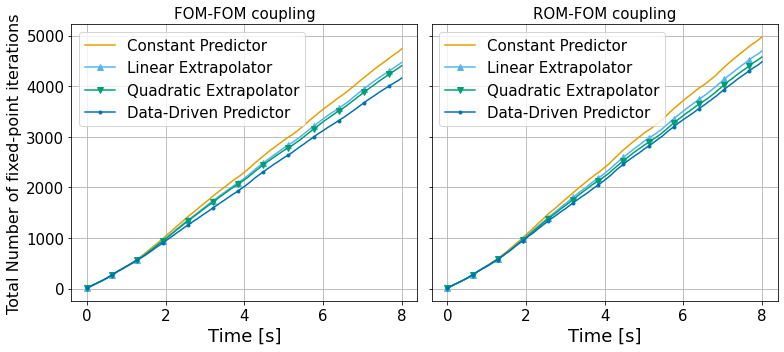

In [8]:
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "-","-","-","-","-","-",
                                  ],
                       marker=["", "^", "v", ".", "", "", ""],
                       markevery=[80, 80, 80, 80, 80, 80, 80]))


fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
ax[0].set_prop_cycle(line_cycler)
ax[1].set_prop_cycle(line_cycler)
time_ = np.arange(0.0, 8.008, 0.008)


ax[1].set_title("ROM-FOM coupling", fontsize = 15);
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/8.33/ConstantExtrapolation/coSimData/iters.npy")), label='Constant Predictor');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/8.33/LinearExtrapolation/coSimData/iters.npy")), label='Linear Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/8.33/QuadraticExtrapolation/coSimData/iters.npy")), label='Quadratic Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/8.33/SurrogatePrediction/coSimData/iters.npy")), label='Data-Driven Predictor');

ax[0].set_title("FOM-FOM coupling", fontsize = 15);
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/8.33/ConstantExtrapolation/coSimData/iters.npy")), label='Constant Predictor');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/8.33/LinearExtrapolation/coSimData/iters.npy")), label='Linear Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/8.33/QuadraticExtrapolation/coSimData/iters.npy")), label='Quadratic Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/8.33/SurrogatePrediction/coSimData/iters.npy")), label='Data-Driven Predictor');


ax[0].set_ylabel("Total Number of fixed-point iterations", fontsize = 16);
ax[0].set_xlabel("Time [s]", fontsize = 18);
ax[1].set_xlabel("Time [s]", fontsize = 18);
ax[0].legend(fontsize = 15);
ax[1].legend(fontsize = 15);

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)


ax[0].grid();
ax[1].grid();

plt.tight_layout();

More specifically, we can see the effect of the new predictors on the accuracy of the initial guess, measuring it using the residual of the FSI fixed point problem. An example is shown here below.

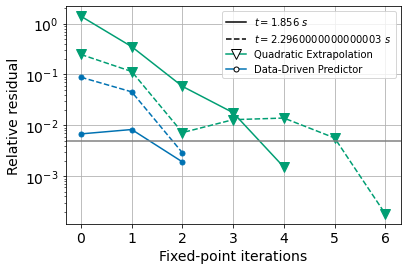

In [9]:
old = np.load("./results/FOM-FOM/8.33/QuadraticExtrapolation/residualInfo/iters.npy")
new = np.load("./results/FOM-FOM/8.33/SurrogatePrediction/residualInfo/iters.npy")
min_= min(len(old), len(new))

line_cycler   = (cycler(color=["#009E73", "#0072B2", "#009E73", "#0072B2", "#0072B2", "#009E73"]) +
                 cycler(linestyle=["-", "-","--","--","-","--"],
                       marker=["v", ".", "v", ".", "", ""],
                       markevery=[1, 1, 1, 1, 1, 1],markersize = [10, 10, 10, 10, 10, 10]))

fig, ax = plt.subplots()
ax.set_prop_cycle(line_cycler)

increm = 232
#increm = np.random.randint(101, min_)
itersCurrentQuad_1 = old.cumsum()[increm]
itersCurrentQuad_0 = itersCurrentQuad_1 - old[increm]
itersCurrentSurr_1 = new.cumsum()[increm]
itersCurrentSurr_0 = itersCurrentSurr_1 - new[increm]
ax.semilogy(np.load("./results/FOM-FOM/8.33/QuadraticExtrapolation/residualInfo/rRelNorm.npy")[itersCurrentQuad_0:itersCurrentQuad_1]);
ax.semilogy(np.load("./results/FOM-FOM/8.33/SurrogatePrediction/residualInfo/rRelNorm.npy")[itersCurrentSurr_0:itersCurrentSurr_1]);
firsT = str(increm*0.008)

increm = 287
#increm = np.random.randint(101, min_)
itersCurrentQuad_1 = old.cumsum()[increm]
itersCurrentQuad_0 = itersCurrentQuad_1 - old[increm]
itersCurrentSurr_1 = new.cumsum()[increm]
itersCurrentSurr_0 = itersCurrentSurr_1 - new[increm]
ax.semilogy(np.load("./results/FOM-FOM/8.33/QuadraticExtrapolation/residualInfo/rRelNorm.npy")[itersCurrentQuad_0:itersCurrentQuad_1]);
ax.semilogy(np.load("./results/FOM-FOM/8.33/SurrogatePrediction/residualInfo/rRelNorm.npy")[itersCurrentSurr_0:itersCurrentSurr_1]);
secondT = str(increm*0.008)


ax.set_xlabel("Fixed-point iterations", fontsize = 14);
ax.set_ylabel("Relative residual", fontsize = 14);

color = np.array([["#E69F00", "#56B4E9"],]*2).transpose()  # Can be other colours than b,g,r
marker0 = ['-', '--']
marker = ['v-', '.-']

#for j in range(3):
#    plt.scatter(x[:,j], y[:,j], c=color[:,j], marker=marker[j])

# legend
label_column = ['Quadratic Extrapolation','Data-Driven Predictor']
label_row = [r'$t='+firsT+'~s$', r'$t='+secondT+'~s$']
rows = [plt.plot([], [], marker0[i], color='k')[0] for i in range(2)]
columns = [plt.plot([], [], marker[i], markerfacecolor='w',
                    markeredgecolor='k')[0] for i in range(2)]

plt.legend(rows + columns, label_row + label_column, loc='best')
ax.axhline(5e-3, color='grey');

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)

plt.grid();

But "How typical are the examples given in the figure above ?".
To answer this question, we can show the distribution of:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- The differences in the number $\Delta{N_{k}^n}$ of iterations at each time step $n$, where $\Delta{N_{k}^n} = N_{k, \text{REF}}^n - N_{k, \text{DD}}$, with $N_{k, \text{REF}}^n$ is the number of iterations-to-convergence with the classical predictors (here comparing the quadratic and constant extrapolations) and $N_{k, \text{DD}}^n$ is the number of iterations-to-convergence using the new data-driven predictor. The occurrence of the $\Delta{N_{k}}^n$ quantities greater than $0$ are indicating a performance gain with the new predictors.
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- he ratios of the initial residuals $\zeta^n$ at each time step $n$, where $\zeta^n = ||\boldsymbol{r}_{\text{REF}}^0||_2^n \;/\; ||\boldsymbol{r}_{\text{DD}}^0||_2^n$. The occurrence of the $\zeta^n$ quantities greater than $1$ are indicating a performance gain with the new predictors.    

In [10]:
surrIters = np.load("results/FOM-FOM/8.33/SurrogatePrediction/residualInfo/iters.npy")
surrFirstIterIndices = (surrIters.cumsum() - surrIters)
surrInitialResiduals = np.load("results/FOM-FOM/8.33/SurrogatePrediction/residualInfo/rNorm.npy")[surrFirstIterIndices]

quadIters = np.load("results/FOM-FOM/8.33/QuadraticExtrapolation/residualInfo/iters.npy")
quadFirstIterIndices = (quadIters.cumsum() - quadIters)
quadInitialResiduals = np.load("results/FOM-FOM/8.33/QuadraticExtrapolation/residualInfo/rNorm.npy")[quadFirstIterIndices]

Iters = np.load("results/FOM-FOM/8.33/ConstantExtrapolation/residualInfo/iters.npy")
FirstIterIndices = (Iters.cumsum() - Iters)
InitialResiduals = np.load("results/FOM-FOM/8.33/ConstantExtrapolation/residualInfo/rNorm.npy")[FirstIterIndices]


differences1 = quadInitialResiduals - surrInitialResiduals
differences2 = quadIters - surrIters
divisions1 = quadInitialResiduals/surrInitialResiduals

differences1ref = InitialResiduals - surrInitialResiduals
differences2ref = Iters - surrIters
divisions1ref = InitialResiduals/surrInitialResiduals

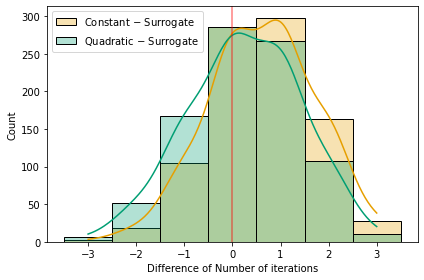

In [11]:
fig, ax = plt.subplots();
plot_data = {'Constant $-$ Surrogate': reject_outliers(differences2ref)[101:], }
g = seaborn.histplot(plot_data['Constant $-$ Surrogate'], discrete=True,
                     label = 'Constant $-$ Surrogate', ax = ax,
                     color='#E69F00', fill = True, alpha = .3,
                     kde=True, binwidth=16, kde_kws={"bw_adjust":1.7});


plot_data = {'Quadratic $-$ Surrogate': reject_outliers(differences2)[101:], }
h = seaborn.histplot(plot_data['Quadratic $-$ Surrogate'], discrete=True,
                     label = 'Quadratic $-$ Surrogate', ax = ax,
                     color='#009E73', fill = True, alpha = .3,
                     kde=True, binwidth=16, kde_kws={"bw_adjust":1.7});

ax.set(xlabel='Difference of Number of iterations');
plt.axvline(0, color='red', alpha = 0.5);
plt.legend();
plt.tight_layout();

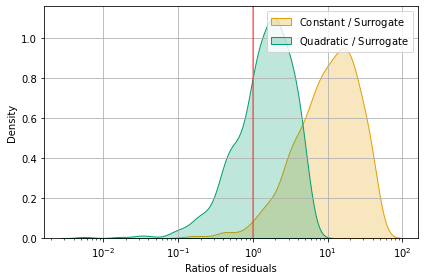

In [12]:
fig, ax = plt.subplots();

plot_data = reject_outliers(divisions1ref, m=4)[101:]
seaborn.kdeplot(data=plot_data,
            fill=True, bw_adjust=1., gridsize=2000,
                log_scale=True, color="#E69F00",label=r'Constant $/$ Surrogate'
               );

plot_data = {'Quadratic $/$ Surrogate': reject_outliers(divisions1, m=4)[101:]}
seaborn.kdeplot(data=plot_data['Quadratic $/$ Surrogate'], ax = ax,
            fill=True, bw_adjust=1., gridsize=2000,
                log_scale=True, color='#009E73', label=r'Quadratic $/$ Surrogate'
              );
plt.legend();
ax.set(xlabel="Ratios of residuals");
plt.axvline(1, color = 'red', alpha = 0.5);
plt.grid();
plt.tight_layout();

# References

[1] [Azzeddine Tiba, Thibault Dairay, Florian De Vuyst, Iraj Mortazavi, Juan-Pedro Berro Ramirez (2024). Machine-Learning Enhanced Predictors for Accelerated Convergence of Partitioned Fluid-Structure Interaction Simulations. arXiv preprint arXiv:2405.09941](https://doi.org/10.48550/arXiv.2405.09941)

[2] [Azzeddine Tiba, Thibault Dairay, Florian De Vuyst, Iraj Mortazavi, Juan-Pedro Berro Ramirez, Non-intrusive reduced order models for partitioned fluid–structure interactions, Journal of Fluids and Structures, Volume 128, 2024, 104156, ISSN 0889-9746.](https://doi.org/10.1016/j.jfluidstructs.2024.104156)